In [12]:
import numpy as np
from utils import *
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Lambda,Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

In [13]:
X_train, Y_train = read_csv('data/train-big.csv') 
X_test, Y_test = read_csv('data/test_minus_dev_big.csv') 
# small 
X_dev, Y_dev = read_csv('data/dev_big.csv')


ratio=0.1
total_train_num=len(X_train)
train_num = int(ratio * total_train_num)
train_index=(np.random.random([train_num])*total_train_num).astype(int)
print (train_num)

X_train=X_train[train_index]
Y_train = Y_train[train_index]


maxLen = len(max(X_train, key=len).split())+10
print(maxLen)

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """

    m = X.shape[0]
    X_indices = np.zeros((m, max_len))
    for i in range(m):
        sentence_words = X[i].lower().split()
        j = 0
        for w in sentence_words:
            if w not in word_to_index:
                X_indices[i, j] = 0 # HACK - FIX SOON
            else:
                if j >= maxLen:
                    print (sentence_words)
                X_indices[i, j] = word_to_index[w]
            j = j+1
    return X_indices

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """

    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["lemon"].shape[0]
    emb_matrix = np.zeros((vocab_len, emb_dim)) # curious why not transpose of this...
    # Sets each row "index" of the embedding matrix to be 
    # the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
    
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)

    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix]) # now it's pretrained!

    return embedding_layer

embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
X_dev_indices = sentences_to_indices(X_dev, word_to_index, maxLen)

9908
35


In [490]:
def Model_V1(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Model-V1 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    sentence_indices = Input(shape = input_shape, dtype = np.int32)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

    # Propagates sentence_indices through the embedding layer
    embeddings = embedding_layer(sentence_indices)

    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    LSTM1 = LSTM(128, return_sequences = True,name='LSTM1')(embeddings)
    # Adds dropout with probability 0.5
    X = Dropout(0.5)(LSTM1)
    # Another LSTM layer, but just returns one output
    LSTM2 = LSTM(128, return_sequences = True, name='LSTM2')(X)
    
    def get_last(X):
        return X[:,-1,:]
    
    LSTM2Last = Lambda(get_last, name='LSTM2-last')(LSTM2)
    Dropout2 = Dropout(0.5,name='Dropout2')(LSTM2Last)
    
    # Propagating through a Dense layer with sigmoid activation to get back a scalar
    Dense1 = Dense(1,name='Dense1')(Dropout2)
    X = Activation('sigmoid',name='output_layer')(Dense1)

    model = Model(inputs = sentence_indices, outputs = X)

    return model

# Adjustable model

In [491]:
def Model_V2(input_shape, word_to_vec_map, word_to_index,num_layer,num_cell,dropout_ratio,bidirectional):
    """
    Function creating the Model-V1 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    sentence_indices = Input(shape = input_shape, dtype = np.int32)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

    # Propagates sentence_indices through the embedding layer
    X = embedding_layer(sentence_indices)
    
    # add the first layer, if there is any.
    if num_layer == 2:
        print (2)
        # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
        if bidirectional == True:
            print ('b1')
            LSTM1 = Bidirectional(LSTM(num_cell, return_sequences = True),name='LSTM1')(X)
        else:
            print('l1')
            LSTM1 = LSTM(num_cell, return_sequences = True,name='LSTM1')(X)
        # Adds dropout with probability 0.5
        X = Dropout(dropout_ratio)(LSTM1)

    # add second layer (or the only layer)
    if  num_layer == 1 and bidirectional == True:
        print ('b2')
        LSTM2 = Bidirectional(LSTM(num_cell, return_sequences = True), name='LSTM2')(X)
    else:
        print ('l2')
    # Another LSTM layer, but just returns one output
        LSTM2 = LSTM(num_cell, return_sequences = True, name='LSTM2')(X)
    
    def get_last(X):
        return X[:,-1,:]
    
    LSTM2Last = Lambda(get_last, name='LSTM2-last')(LSTM2)
    Dropout2 = Dropout(dropout_ratio,name='Dropout2')(LSTM2Last)
    
    # Propagating through a Dense layer with sigmoid activation to get back a scalar
    Dense1 = Dense(1,name='Dense1')(Dropout2)
    X = Activation('sigmoid',name='output_layer')(Dense1)

    model = Model(inputs = sentence_indices, outputs = X)

    return model

# Training the model

In [492]:
#model
num_layer=[1] # index 0 is better
num_cell=[64] # 0 index
drop_ratio=[0.3] # 2 index
bidirectional=[False] # 0 index

# optimizer
beta1=0.9
beta2=0.999

#fitting
learning_rate=[0.001]#[0.001,0.002,0.003,0.004]
batch_size=[300]#[5,10,15,20,25]

In [493]:
il=0
ic=0
idr=0
ibr=0
# might want to change the metric here
model = Model_V2((maxLen,), word_to_vec_map, word_to_index,num_layer[il],num_cell[ic],drop_ratio[idr],bidirectional[ibr])
optimizer = Adam(lr=learning_rate[ilr], beta_1=beta1, beta_2=beta2, decay=0.0, epsilon=None)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# train the model
model_fitting = model.fit(X_train_indices, Y_train, epochs = 20, batch_size = batch_size[ibs], shuffle=True,validation_data=(X_dev_indices, Y_dev))
loss, acc = model.evaluate(X_test_indices, Y_test)
model.save('word_model_PB.h5')
print("Test accuracy = ", acc)
val_acc[il][ic][idr][ibr][ilr][ibs] = model_fitting.history['val_acc'][-1]
tra_acc[il][ic][idr][ibr][ilr][ibs] = model_fitting.history['acc'][-1]

l2
Train on 9908 samples, validate on 184 samples
Epoch 1/20
9908/9908 [==============================] - 14s 1ms/step - loss: 0.6925 - acc: 0.5078 - val_loss: 0.6962 - val_acc: 0.4348
Epoch 2/20
9908/9908 [==============================] - 2s 212us/step - loss: 0.6804 - acc: 0.5665 - val_loss: 0.7254 - val_acc: 0.5326
Epoch 3/20
9908/9908 [==============================] - 2s 212us/step - loss: 0.6350 - acc: 0.6434 - val_loss: 0.5294 - val_acc: 0.7663
Epoch 4/20
9908/9908 [==============================] - 2s 213us/step - loss: 0.5866 - acc: 0.6941 - val_loss: 0.4518 - val_acc: 0.8261
Epoch 5/20
9908/9908 [==============================] - 2s 212us/step - loss: 0.5566 - acc: 0.7173 - val_loss: 0.4469 - val_acc: 0.8098
Epoch 6/20
9908/9908 [==============================] - 2s 219us/step - loss: 0.5203 - acc: 0.7458 - val_loss: 0.5512 - val_acc: 0.7446
Epoch 7/20
9908/9908 [==============================] - 2s 215us/step - loss: 0.5257 - acc: 0.7427 - val_loss: 0.4303 - val_acc: 0.8261

In [ ]:
[0.8414 ,0.9076]

# Hyper parameter Tuning

In [ ]:
for il in range(len(num_layer)):
    for ic in range(len(num_cell)):
        for idr in range(len(drop_ratio)):
            for ibr in range(len(bidirectional)):
                for ilr in range(len(learning_rate)):
                    for ibs in range(len(batch_size)):
                        print ('num_layer:'+str(num_layer[il]),'num_cell:'+str(num_cell[ic]),'drop_ratio:'+str(drop_ratio[idr]),'bidirectional:'+str(bidirectional[ibr]))
                        print('val_acc'+str(val_acc[il][ic][idr][ibr][ilr][ibs]),'tra_acc'+str(tra_acc[il][ic][idr][ibr][ilr][ibs]))

In [ ]:
val_acc=np.zeros([len(num_layer),len(num_cell),len(drop_ratio),len(bidirectional),len(learning_rate),len(batch_size)])
tra_acc=np.zeros([len(num_layer),len(num_cell),len(drop_ratio),len(bidirectional),len(learning_rate),len(batch_size)])
for il in range(len(num_layer)):
    for ic in range(len(num_cell)):
        for idr in range(len(drop_ratio)):
            for ibr in range(len(bidirectional)):
                for ilr in range(len(learning_rate)):
                    for ibs in range(len(batch_size)):
                        # might want to change the metric here
                        model = Model_V2((maxLen,), word_to_vec_map, word_to_index,num_layer[il],num_cell[ic],drop_ratio[idr],bidirectional[ibr])
                        optimizer = Adam(lr=learning_rate[ilr], beta_1=beta1, beta_2=beta2, decay=0.0, epsilon=None)
                        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
                        # train the model
                        model_fitting = model.fit(X_train_indices, Y_train, epochs = 20, batch_size = batch_size[ibs], shuffle=True,validation_data=(X_dev_indices, Y_dev))
                        loss, acc = model.evaluate(X_test_indices, Y_test)
                        model.save('my_model.h5')
                        print("Test accuracy = ", acc)
                        val_acc[il][ic][idr][ibr][ilr][ibs] = model_fitting.history['val_acc'][-1]
                        tra_acc[il][ic][idr][ibr][ilr][ibs] = model_fitting.history['acc'][-1]
                    

In [ ]:
print(val_acc.shape)
np.mean(val_acc[:,:,:,:,:,:,:])

# Weight Plot

In [7]:
model_fitting.history['val_acc'][-1]
model_fitting.history['acc'][-1]

NameError: name 'model_fitting' is not defined

In [5]:
from __future__ import print_function

from keras import backend as K
from keras.engine import Input, Model, InputSpec
from keras.layers import Dense, Activation, Dropout, Lambda
from keras.layers import Embedding, LSTM
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.utils.data_utils import get_file
from keras.datasets import imdb

import numpy as np
import random
import sys
import pdb

Using TensorFlow backend.


In [6]:
# Loading the model
from keras.models import load_model
model = load_model('word_1lay_64cell_30drop_1dir_60ep_50kex.h5')

In [8]:
def visualize_model_bs(model, include_gradients=False):

    LSTM2 = model.get_layer('LSTM2')
    Dropout2 = model.get_layer('Dropout2')
    output_layer = model.get_layer('output_layer')

    inputs = []
    inputs.extend(model.inputs)

    outputs = []
    outputs.extend(model.outputs)
    outputs.append(LSTM2.output)
    outputs.append(LSTM2.cell.kernel_f)  # -- weights of the forget gates (assuming LSTM)
    #print (LSTM1.trainable_weights)

    if include_gradients:
        loss = K.mean(model.output)  # [batch_size, 1] -> scalar
        grads = K.gradients(loss, LSTM2.output)
        grads_norm = grads / (K.sqrt(K.mean(K.square(grads))) + 1e-5)
        outputs.append(grads_norm)

    all_function = K.function(inputs, outputs)
    output_function = K.function([Dropout2.input], model.outputs)
    print(Dropout2.input)
    return all_function, output_function

In [ ]:
def getWeightedOutputs(model):

    LSTM2 = model.get_layer('LSTM2')
    Dense1 = model.get_layer('Dense1')

    weightedOutputs = LSTM2.output * Dense1.get_weights()

    return K.function(model.inputs, weightedOutputs)
    

In [9]:

all_function, output_function = visualize_model_bs(model, include_gradients=True)

Tensor("LSTM2-last/strided_slice:0", shape=(?, 64), dtype=float32)


In [14]:
sentence="I like the way you think think think think think think"
t = np.array([sentence])
X = sentences_to_indices(t, word_to_index, maxLen)
# -- Return scores, raw rnn values and gradients
# scores is equivalent to model.predict(X)
scores, rnn_values, rnn_gradients, W_i = all_function([X])
print(scores.shape, rnn_values.shape, rnn_gradients.shape, W_i.shape)

# -- score prediction
print("Scores:", scores)

# -- Return scores at each step in the time sequence
time_distributed_scores = map(lambda x: output_function([x]), rnn_values)
print("Time distributed (word-level) scores:", map(lambda x: x[0], time_distributed_scores))


(1, 1) (1, 35, 64) (50, 64) (1, 1, 35, 64)
Scores: [[0.5273786]]
Time distributed (word-level) scores: [array([[0.5292262 ],
       [0.60930586],
       [0.7797758 ],
       [0.67087257],
       [0.57521385],
       [0.76162696],
       [0.7860274 ],
       [0.7751681 ],
       [0.7585693 ],
       [0.7478044 ],
       [0.7440752 ],
       [0.5625093 ],
       [0.55784297],
       [0.5774576 ],
       [0.61416   ],
       [0.66246104],
       [0.71662575],
       [0.772387  ],
       [0.82495326],
       [0.8691724 ],
       [0.90199864],
       [0.9237125 ],
       [0.936372  ],
       [0.94181436],
       [0.94056755],
       [0.9309745 ],
       [0.9070768 ],
       [0.8525909 ],
       [0.7279502 ],
       [0.4801502 ],
       [0.19076174],
       [0.0457784 ],
       [0.00930508],
       [0.5273786 ],
       [0.5273786 ]], dtype=float32)]


In [25]:
print(maxLen)

35


In [16]:
# choose the color index
from colored import fg, bg, attr
min_c=0
max_c=255
for i in range(min_c,max_c):
    print ('%s%s' % (bg (i),str(i)),end="")
    
print('\n------Color index:-----')

color_index=[196,197,198,205,212,219,225,231,229,193,192,191,155,154,82]
for i in color_index:
    print ('%s%s' % (bg (i),str(i)),end="")

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203204205206207208209210211212213214215216217218219220221222223224225226227228229230231232233234235236237238239240241242243244245246247248249250251252253254
------Color index:-----
19619719820521221922523122919319219115515482

In [22]:
from colored import fg, bg, attr
words=sentence.split()

rnn_shape=[1, 35, 64]
color_index=[196,197,198,205,212,219,225,231,229,193,192,191,155,154,82]
len_color=len(color_index)
color_weight=np.array(rnn_values)
color_weight_range=(max(color_weight.flatten())-min(color_weight.flatten()))
color_weight=len_color*(color_weight-min(color_weight.flatten()))/color_weight_range
color_weight=color_weight.reshape(rnn_shape)


# color tuning
min_c=int(min(color_weight.flatten()))
max_c=int(max(color_weight.flatten()))
print(min_c,max_c)

    
print("")

def clamp(x, minval, maxval):
    return max(minval, min(x, maxval))

rnn_shape=rnn_values.shape
for i in range(rnn_shape[2]):
    #for w in range(rnn_shape[2]):
    for w in range(len(words)):
        idx = clamp(int(color_weight[0,w,i]), 0, len(color_index)-1)
        print ('%s%s' % (bg (color_index[idx]),words[w]),end="")
        print (' ' ,end="")
    print ('')

0 15

I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think

I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 
I like the way you think think think think think think 


In [23]:
rnn_shape[2]

64

In [272]:
from colored import fg, bg, attr

words=sentence.split()
base=124
scale=6
color_weight=base+np.array(time_distributed_scores).reshape(maxLen)*scale

for i in range(len(words)):
    print ('%s%s' % (bg (int(color_weight[i])),words[i]),end="")
    print ('%s '%attr(1) ,end="")

    

You do me wrong very have a of months immediate 

# Data processing dev/test/train

In [494]:
# small 
X_test, Y_test = read_csv('data/test.csv') 

In [495]:
# small
import pandas as pd
dev_ratio=0.1
total_test_num=len(X_test_indices)
dev_num = int(dev_ratio * len(X_test_indices))
X_dev_indices = []
print (dev_num)
dev_index=(np.random.random([dev_num])*total_test_num).astype(int)

X_dev_indices=X_test_indices[dev_index,:]
X_dev = X_test[dev_index]
Y_dev = Y_test[dev_index]

X_test_after_dev=np.delete(X_test,dev_index,0)
Y_test_after_dev=np.delete(Y_test,dev_index,0)

# test after dev
test_after_dev={'X': X_test_after_dev, 'Y': Y_test_after_dev}
test_after_dev = pd.DataFrame(test_after_dev)
test_after_dev.to_csv('test_minus_dev.csv',header=False,index=False)

# dev
dev={'X': X_dev, 'Y': Y_dev}
dev = pd.DataFrame(dev)
dev.to_csv('dev.csv',header=False,index=False)

166


In [496]:
# big
X_test, Y_test = read_csv('data/test-big.csv')

# small
import pandas as pd
dev_ratio=0.1
total_test_num=len(X_test_indices)
dev_num = int(dev_ratio * len(X_test_indices))
X_dev_indices = []
print (dev_num)
dev_index=(np.random.random([dev_num])*total_test_num).astype(int)

X_dev_indices=X_test_indices[dev_index,:]
X_dev = X_test[dev_index]
Y_dev = Y_test[dev_index]

X_test_after_dev=np.delete(X_test,dev_index,0)
Y_test_after_dev=np.delete(Y_test,dev_index,0)

# test after dev
test_after_dev={'X': X_test_after_dev, 'Y': Y_test_after_dev}
test_after_dev = pd.DataFrame(test_after_dev)
test_after_dev.to_csv('test_minus_dev_big.csv',header=False,index=False)

# dev
dev={'X': X_dev, 'Y': Y_dev}
dev = pd.DataFrame(dev)
dev.to_csv('dev_big.csv',header=False,index=False)

166


In [391]:
# big
X_train, Y_train = read_csv('data/train-big.csv')

# small
import pandas as pd
ratio=0.1
total_train_num=len(X_train)
train_num = int(ratio * total_train_num)
print (train_num)
train_index=(np.random.random([train_num])*total_train_num).astype(int)

X_train=X_train[train_index]
Y_train = Y_train[train_index]


# train 
X_train_shrink={'X': X_train, 'Y': Y_train}
X_train_shrink = pd.DataFrame(X_train_shrink)
X_train_shrink.to_csv('train_shrink.csv',sep=',',header=False,index=False)

9908


In [393]:
maxLen = len(max(X_train, key=len).split())
print(maxLen)

38


# Plot the accuracy history during the training

In [497]:
import matplotlib.pyplot as plt
%matplotlib inline


In [498]:
history_acc_percentage=np.array(model_fitting.history['acc'][:20])*100
history_dev_percentage=np.array(model_fitting.history['val_acc'][:20])*100

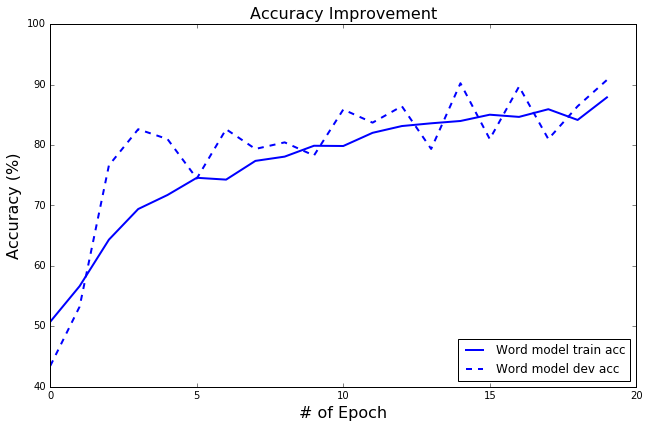

In [499]:
fig = plt.gcf()
fig.set_size_inches(10.5, 6.5)

word_train,=plt.plot(history_acc_percentage, linewidth=2,color='blue',linestyle='-',label='Word model train acc')
word_dev,=plt.plot(history_dev_percentage, linewidth=2,color='blue',linestyle='--',label='Word model dev acc')
plt.xlabel('# of Epoch',fontsize=16)
plt.ylabel('Accuracy (%)',fontsize=16)
plt.title('Accuracy Improvement',fontsize=16)
plt.legend(handles=[word_train,word_dev],fontsize=12,loc=4)

plt.show()
fig.savefig('test2png.png', dpi=100)

In [501]:
sum(Y_train)

4914